In [3]:
import sys, os
print(sys.executable)
print(sys.path)

import platform 
#print(platform.python_version())

/nfs/juhu/data/rakhasan/keras-env/bin/python
['/nfs/juhu/data/rakhasan/keras-env/lib/python36.zip', '/nfs/juhu/data/rakhasan/keras-env/lib/python3.6', '/nfs/juhu/data/rakhasan/keras-env/lib/python3.6/lib-dynload', '', '/u/rakhasan/.local/lib/python3.6/site-packages', '/u/rakhasan/.local/lib/python3.6/site-packages/mask_rcnn-2.1-py3.6.egg', '/nfs/juhu/data/rakhasan/keras-env/lib/python3.6/site-packages', '/nfs/juhu/data/rakhasan/keras-env/lib/python3.6/site-packages/IPython/extensions', '/nfs/nfs7/home/rakhasan/.ipython']


In [ ]:
import glob

#from tqdm import tqdm
import numpy as np
import scipy.ndimage
import scipy.misc
import pandas as pd
import pickle
from IPython.display import clear_output

import keras
from keras.layers.core import Dense, Flatten, Dropout
from keras.layers import Concatenate
from keras.layers import Input
from keras.layers.normalization import BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Model

from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
# import the necessary packages
from keras.preprocessing import image as image_utils
from keras.utils import plot_model
from keras import backend as K
from keras.regularizers import Regularizer


from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn import svm
#from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
#from sklearn import cross_validation, grid_search
import keras_metrics
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

from scipy import stats

import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/keras-team/keras/issues/2280#issuecomment-306959926
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess) # reference: https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer

import sys


In [8]:
IMG_SIZE = (256, 256)
IN_SHAPE = (*IMG_SIZE, 3)
BATCH_SIZE = 64

In [11]:
openImg_path = '/nfs/juhu/data/rakhasan/bystander-detection/google-img-db/'
survey_path='/nfs/juhu/data/rakhasan/bystander-detection/pilot-study2/'
survey_photo_path = survey_path+'/photos/'

model_output_path = '/nfs/juhu/data/rakhasan/bystander-detection/code-repos/notebooks/model-output/'

print('loading features.')
'''Note: this data frame has all deep features, and the label is binary values (0,1)'''
feature_df = pd.read_pickle('/nfs/juhu/data/rakhasan/bystander-detection/pilot-study2/'+'all-features-df-2019-10-30.pkl')#(os.path.join(survey_path, 'features-df-all.pkl'))
#feature_df = feature_df[(feature_df.label==1)|(feature_df.label==-1)]
#feature_df['label'] = feature_df.apply(lambda row: 1 if row.label==1 else 0, axis=1)
print('dataset:',len(feature_df), 'unique labels:', feature_df.label.unique(),
     'pos:',len(feature_df[feature_df.label==1]),'neg:',len(feature_df[feature_df.label==-1]))

loading features.
dataset: 4080 unique labels: [ 1 -1  0] pos: 2287 neg: 1515


In [13]:
'''Feature names'''

#joint names labeled by openpose
body_joint_names = ['nose', 'neck', 'Rsho', 'Relb', 'Rwri', 'Lsho', 'Lelb',
               'Lwri', 'Rhip', 'Rkne', 'Rank', 'Lhip', 'Lkne', 'Lank', 
               'Leye', 'Reye', 'Lear', 'Rear']

#angles between pairs of body joint, from openpose
link_angle_features = ['angle_'+str(i) for i in range(17)]

#probability of detecting a body joint, from openpose
body_joint_prob_features = [j + '_prob' for j in body_joint_names]

face_exp_feaures = ['angry', 'disgusted', 'fearful', 'happy', 'sad', 'surprised', 'neutral']

img_level_features = ['person_distance', 'person_size', 'num_people']

visual_features = img_level_features +\
    link_angle_features + body_joint_prob_features + face_exp_feaures

features_from_study = ['was_aware_num',  'posing_num',  'comfort_num',  'will_num', 'photographer_intention_num',
     'replacable_num',  'photo_place_num']

resnet_feature_cols = ['resnet_feat_{}'.format(i) for i in range(131071)]

resnet_feat_avg_cols = ['resnet_feat_avg_{}'.format(i) for i in range(2048)]

all_features = features_from_study + visual_features + resnet_feat_avg_cols

In [5]:
from keras import optimizers

def linear_regression_model(input_dim=38, hidden_dims = []):
    '''Create a fully connected network with first layer as input with input_dim=input_dim,
    and len(hidden_dims) number of hidden layers.
    
    Currenly default activation is relu for all hidden layers, and a dropout(.5) is added.
    
    '''
    
    input_layer = Input(shape=(input_dim,), name = 'input_layer')
    hidden_layer = input_layer
    if hidden_dims:
        for hidden_dim in hidden_dims:
            hidden_layer = Dense(hidden_dim, activation='relu')(hidden_layer)
            hidden_layer = Dropout(.5)(BatchNormalization()(hidden_layer))
    
    output_layer = Dense(1, kernel_regularizer=keras.regularizers.l2(1), bias_regularizer=keras.regularizers.l2(1), 
                         activation = 'linear')(hidden_layer)
    
    model = Model(input_layer, output_layer)
    
    model.compile(optimizer=optimizers.SGD( lr = 0.01, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=0.5),
                  loss='mse',
                  metrics=['mse','mae'])
    return model

def do_cross_validation(model_func, X,Y, n_splits=5, epochs=20, save_model = False,
                        save_prefix='', model_args=None, verbose=1):
    seed = 1234
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    cvscores = []
    
    fold = 0
    splits = []
    for train, test in kfold.split(X, (Y>0).astype(int)):
        # create model
        if model_args:
            model = model_func(model_args['input_dim'], model_args['hidden_dims'])
        else:
            model = model_func()
        model.fit(X[train], Y[train], epochs=epochs, batch_size=BATCH_SIZE, verbose=verbose)
        #evaluate the model
        score = model.evaluate(X[test], Y[test], verbose=1)
        print('metrics:{}, values:{}'.format(model.metrics_names, score))
        cvscores.append(score)
        
        if save_model:
            model.save_weights(model_output_path+'model_{}_{}.weights'.format(save_prefix, fold))
            fold+=1
            splits.append((train, test))
    
    if save_model:
        pickle.dump(splits, open(model_output_path+'splits_{}'.format(save_prefix), 'wb'))

    return cvscores

# Paper analyses

## Step1: predict high level features

In [40]:
#feat = resnet_feat_avg_cols + img_level_features + link_angle_features + body_joint_prob_features + face_exp_feaures
feat = resnet_feat_avg_cols  + link_angle_features + body_joint_prob_features + face_exp_feaures

will_model = linear_regression_model(input_dim=len(feat), hidden_dims=[64])
will_model.fit(feature_df[feat].apply(stats.zscore).values, feature_df['will_num'],
          epochs=30, batch_size=BATCH_SIZE, verbose=0)
feature_df['predicted_will'] = will_model.predict(feature_df[feat].apply(stats.zscore).values)

comfort_model = linear_regression_model(input_dim=len(feat), hidden_dims=[64])
comfort_model.fit(feature_df[feat].apply(stats.zscore).values, feature_df.comfort_num,
          epochs=30, batch_size=BATCH_SIZE, verbose=0)
feature_df['predicted_comfort'] =comfort_model.predict(feature_df[feat].apply(stats.zscore).values)


aware_model = linear_regression_model(input_dim=len(feat), hidden_dims=[64])
aware_model.fit(feature_df[feat].apply(stats.zscore).values, feature_df.was_aware_num,
          epochs=30, batch_size=BATCH_SIZE, verbose=0)
feature_df['predicted_aware'] = aware_model.predict(feature_df[feat].apply(stats.zscore).values)

pose_model = linear_regression_model(input_dim=len(feat), hidden_dims=[64])
pose_model.fit(feature_df[feat].apply(stats.zscore).values, feature_df.posing_num,
          epochs=30, batch_size=BATCH_SIZE, verbose=0)
feature_df['predicted_posing'] = pose_model.predict(feature_df[feat].apply(stats.zscore).values)

replace_model = linear_regression_model(input_dim=len(feat), hidden_dims=[64])
replace_model.fit(feature_df[feat].apply(stats.zscore).values, feature_df.replacable_num,
          epochs=30, batch_size=BATCH_SIZE, verbose=0)
feature_df['predicted_replace'] =replace_model.predict(feature_df[feat].apply(stats.zscore).values)


intention_model = linear_regression_model(input_dim=len(feat), hidden_dims=[64])
intention_model.fit(feature_df[feat].apply(stats.zscore).values, feature_df.photographer_intention_num,
          epochs=30, batch_size=BATCH_SIZE, verbose=0)
feature_df['predicted_intention'] =intention_model.predict(feature_df[feat].apply(stats.zscore).values)

## Step2: test classification accuracy for ground truth VS. predicted features

### Classification with predicted features

In [2]:
feat=['predicted_posing', 'predicted_replace', 'predicted_intention','person_size']
print('Features:',feat)
helper.do_cross_val_roc(classifier_func=LogisticRegression,
                        X=feature_df[feat].apply(stats.zscore).values,
                        y = feature_df.label.values,
                        legend_font=16,
                        label_font=28,
                        forLatex=True,
                        save_file='/Users/rakhasan/Publc/predicted-pose-roc.pdf',                        
                        )


Features: ['predicted_posing', 'predicted_replace', 'predicted_intention', 'person_size']


NameError: name 'helper' is not defined

Features: ['predicted_posing', 'predicted_replace', 'predicted_intention']
             precision    recall  f1-score   support

          0       0.87      0.86      0.86       152
          1       0.91      0.92      0.91       229

avg / total       0.89      0.89      0.89       381

             precision    recall  f1-score   support

          0       0.86      0.74      0.80       152
          1       0.84      0.92      0.88       229

avg / total       0.85      0.85      0.85       381

             precision    recall  f1-score   support

          0       0.86      0.84      0.85       152
          1       0.90      0.91      0.90       229

avg / total       0.88      0.88      0.88       381

             precision    recall  f1-score   support

          0       0.83      0.79      0.81       152
          1       0.86      0.89      0.88       229

avg / total       0.85      0.85      0.85       381

             precision    recall  f1-score   support

          0

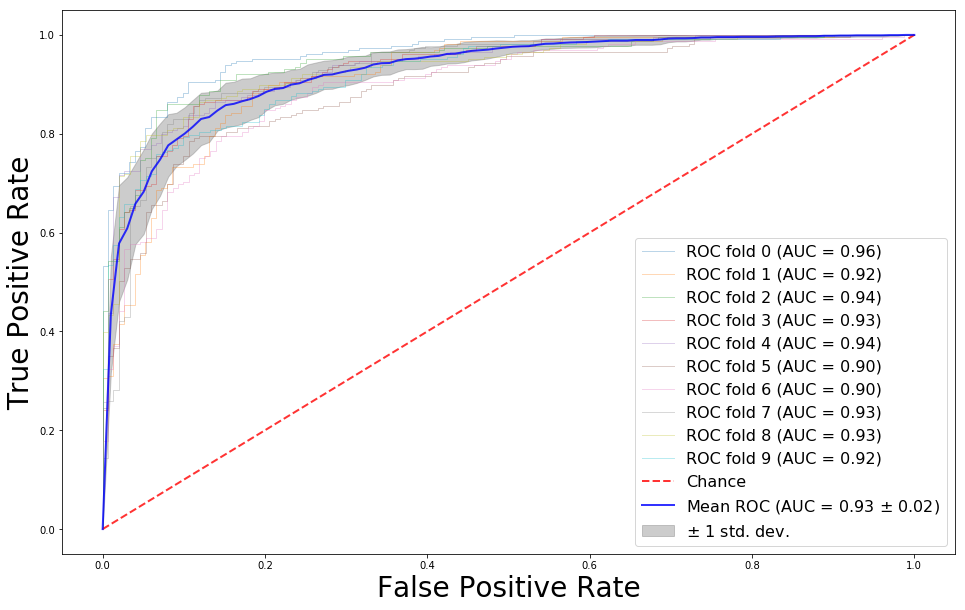

Accuracy scores: [0.8923884514435696, 0.847769028871391, 0.8818897637795275, 0.8503937007874016, 0.8503937007874016, 0.8210526315789474, 0.8131578947368421, 0.8496042216358839, 0.8654353562005277, 0.8311345646437994]
Mean accuracy:0.8503219314465292(+/-0.02)


In [51]:
'''save plot for paper'''
feat=['predicted_posing', 'predicted_replace', 'predicted_intention']
print('Features:',feat)
helper.do_cross_val_roc(classifier_func=LogisticRegression,
                        X=feature_df[feat].apply(stats.zscore).values,
                        y = feature_df.label.values,
                        save_file='predicted-pose-roc.pdf',
                        legend_font=16,
                        label_font=28,
                        )

## Compare with human agreement

In [59]:
low_agreement = pickle.load(open(survey_path+'low-agreement.pkl','rb'))
agreement_23 = pickle.load(open(survey_path+'agreement23.pkl','rb'))
agreement_100 = pickle.load(open(survey_path+'agreement100.pkl','rb'))

(1309, 1308, 3802)

             precision    recall  f1-score   support

          0       0.98      0.85      0.91        48
          1       0.92      0.99      0.95        84

avg / total       0.94      0.94      0.94       132

             precision    recall  f1-score   support

          0       0.94      0.96      0.95        47
          1       0.98      0.96      0.97        84

avg / total       0.96      0.96      0.96       131

             precision    recall  f1-score   support

          0       0.92      0.94      0.93        47
          1       0.96      0.95      0.96        84

avg / total       0.95      0.95      0.95       131

             precision    recall  f1-score   support

          0       0.92      0.94      0.93        47
          1       0.96      0.95      0.96        84

avg / total       0.95      0.95      0.95       131

             precision    recall  f1-score   support

          0       0.86      0.94      0.90        47
          1       0.96      0.92 

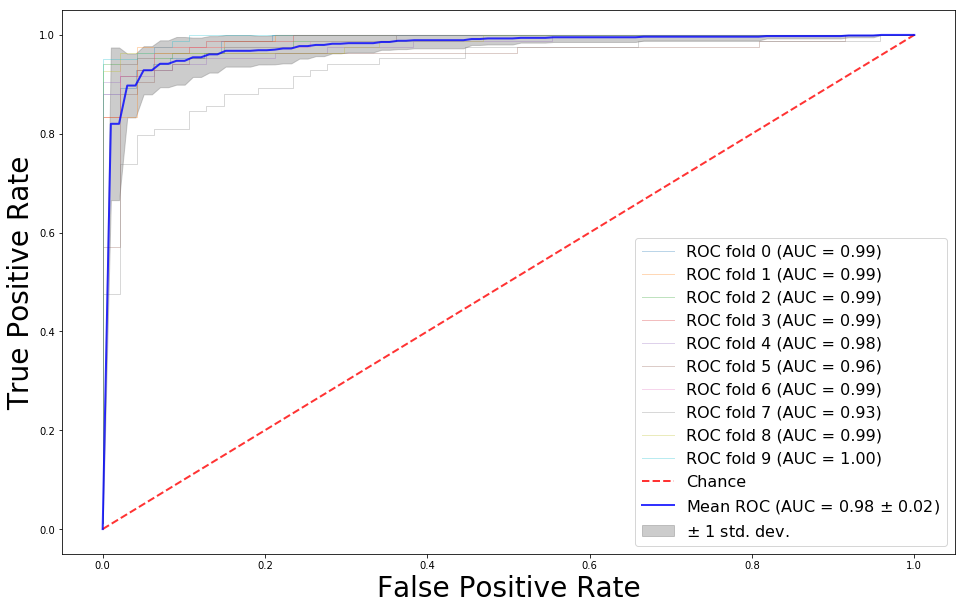

Accuracy scores: [0.9393939393939394, 0.9618320610687023, 0.9465648854961832, 0.9465648854961832, 0.9236641221374046, 0.9236641221374046, 0.9465648854961832, 0.8549618320610687, 0.9384615384615385, 0.9615384615384616]
Mean accuracy:0.934321073328707(+/-0.03)


In [52]:
'''
Split 100% agreement data for training and testing
'''
df = feature_df.loc[agreement_100][feat+['label']]
helper.do_cross_val_roc(classifier_func=LogisticRegression,
                        X=df[feat].apply(stats.zscore).values, 
                        y = df.label.values,
                        legend_font=16,
                        label_font=28,
                        save_file='100-perc-agreement-roc.pdf')

             precision    recall  f1-score   support

          0       0.78      0.65      0.71        54
          1       0.78      0.87      0.82        78

avg / total       0.78      0.78      0.78       132

             precision    recall  f1-score   support

          0       0.82      0.74      0.78        54
          1       0.83      0.88      0.86        78

avg / total       0.83      0.83      0.82       132

             precision    recall  f1-score   support

          0       0.80      0.81      0.81        54
          1       0.87      0.86      0.86        78

avg / total       0.84      0.84      0.84       132

             precision    recall  f1-score   support

          0       0.77      0.76      0.77        54
          1       0.84      0.85      0.84        78

avg / total       0.81      0.81      0.81       132

             precision    recall  f1-score   support

          0       0.73      0.81      0.77        53
          1       0.86      0.79 

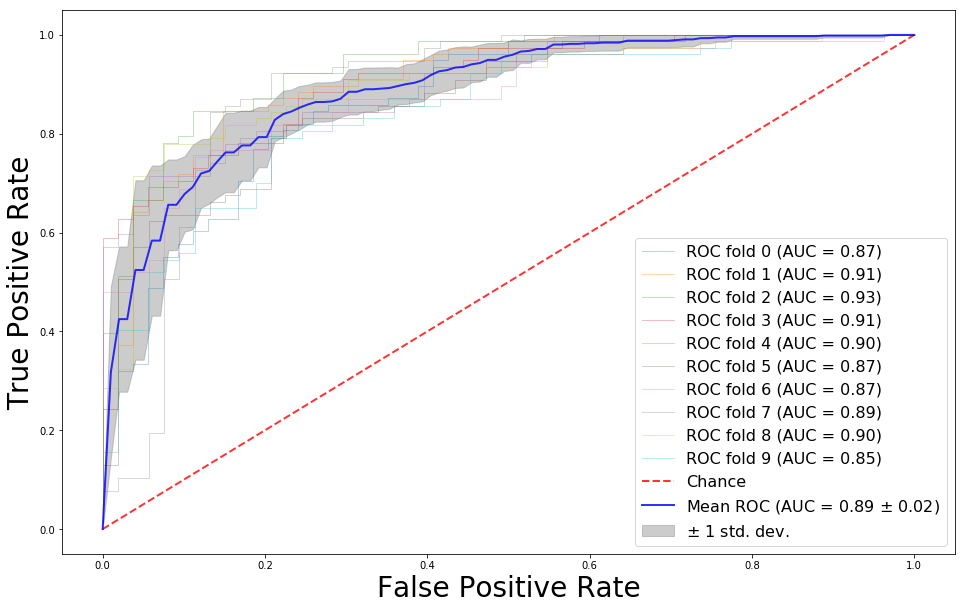

Accuracy scores: [0.7803030303030303, 0.8257575757575758, 0.8409090909090909, 0.8106060606060606, 0.8, 0.7923076923076923, 0.8, 0.823076923076923, 0.8307692307692308, 0.7692307692307693]
Mean accuracy:0.8072960372960372(+/-0.02)


In [62]:
'''
Split 67% agreement data for training and testing
'''
df = feature_df.loc[agreement_23][feat+['label']]
helper.do_cross_val_roc(classifier_func=LogisticRegression,
                        X=df[feat].apply(stats.zscore).values, 
                        y = df.label.values,
                        legend_font=16,
                        label_font=28,
                       save_file='67-perc-agreement-roc.pdf')

In [63]:
len(low_agreement)

584

             precision    recall  f1-score   support

          0       0.86      0.77      0.81        31
          1       0.78      0.86      0.82        29

avg / total       0.82      0.82      0.82        60

             precision    recall  f1-score   support

          0       0.65      0.71      0.68        31
          1       0.64      0.57      0.60        28

avg / total       0.64      0.64      0.64        59

             precision    recall  f1-score   support

          0       0.74      0.84      0.79        31
          1       0.79      0.68      0.73        28

avg / total       0.77      0.76      0.76        59

             precision    recall  f1-score   support

          0       0.74      0.67      0.70        30
          1       0.68      0.75      0.71        28

avg / total       0.71      0.71      0.71        58

             precision    recall  f1-score   support

          0       0.79      0.73      0.76        30
          1       0.73      0.79 

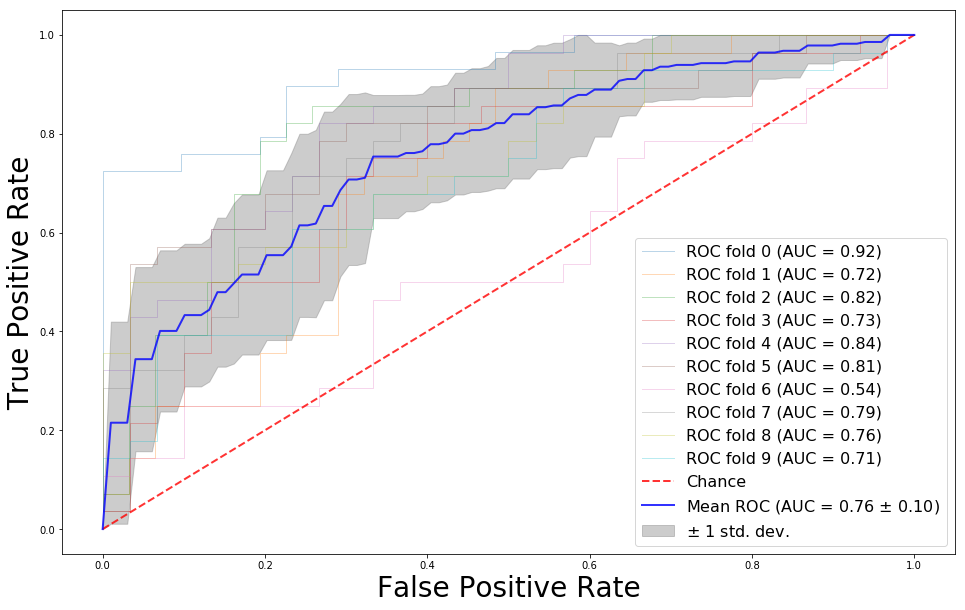

Accuracy scores: [0.8166666666666667, 0.6440677966101694, 0.7627118644067796, 0.7068965517241379, 0.7586206896551724, 0.7413793103448276, 0.5344827586206896, 0.7068965517241379, 0.6379310344827587, 0.6724137931034483]
Mean accuracy:0.6982067017338788(+/-0.08)


In [61]:
'''
Use images that have less than 67% agreement
'''
#low_agreement = list(set(feature_df.index).difference(set(agreement_100).union(set(agreement_23))))
df = feature_df.loc[low_agreement][feat+['label']]
helper.do_cross_val_roc(classifier_func=LogisticRegression,
                        X=df[feat].apply(stats.zscore).values, 
                        y = df.label.values,
                        legend_font=16,
                        label_font=28,
                       save_file='low-agreement-roc.pdf')

/nfs/nfs5-insecure/home/insecure-ro/software/rhel6_x86_64/anaconda3-4.3.0/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


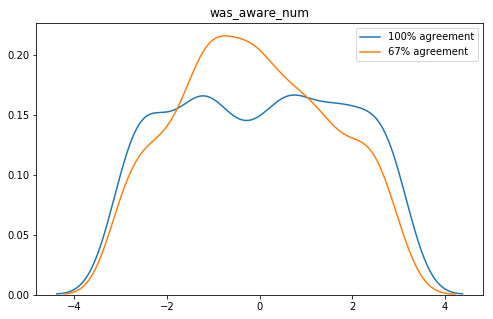

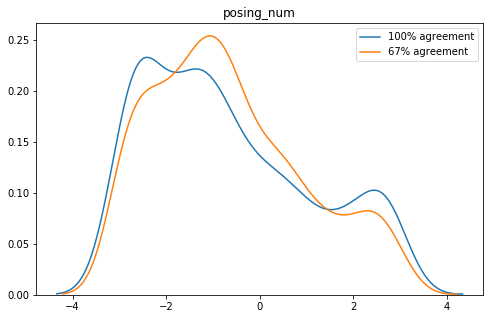

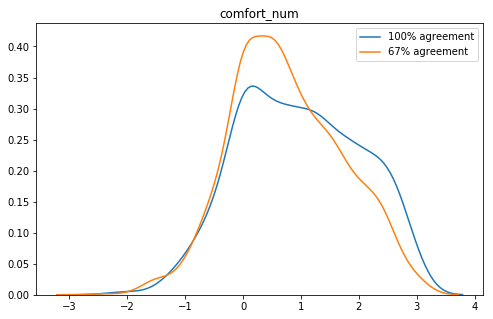

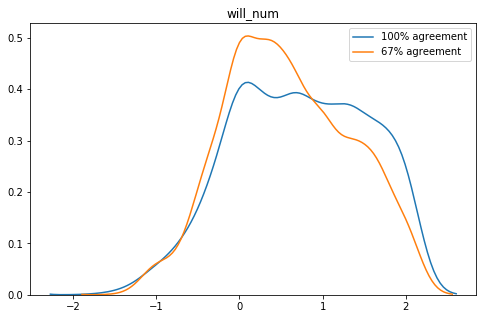

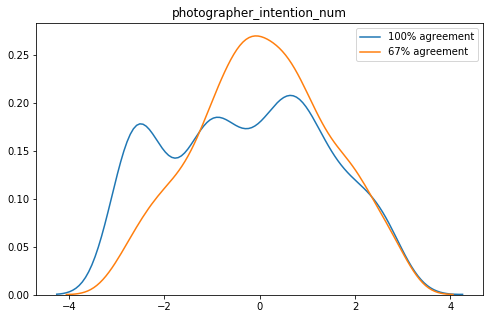

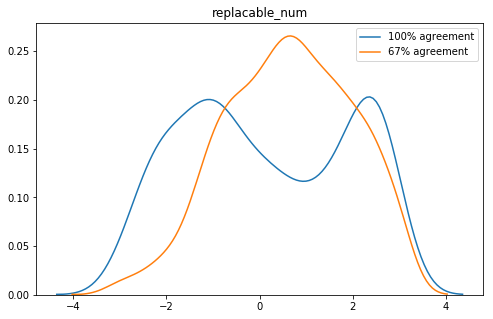

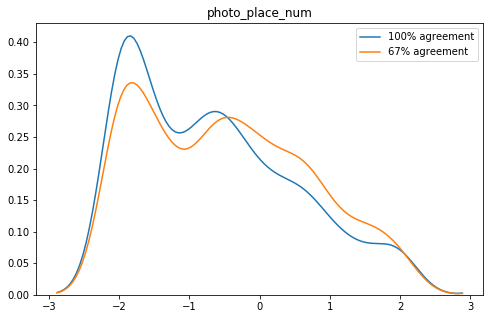

In [33]:
'''How different are the features when 67% vs 100 agreement?'''
import seaborn as sns
features_from_study = ['was_aware_num',  'posing_num',  'comfort_num',  'will_num', 'photographer_intention_num',
     'replacable_num',  'photo_place_num']

for f in features_from_study:
    plt.figure(figsize=(8,5))
    sns.kdeplot(feature_df.loc[agreement_100][f],  label='100% agreement')
    sns.kdeplot(feature_df.loc[agreement_23][f], label='67% agreement')
    plt.title(f)
    plt.legend()
    plt.show()


/nfs/nfs5-insecure/home/insecure-ro/software/rhel6_x86_64/anaconda3-4.3.0/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


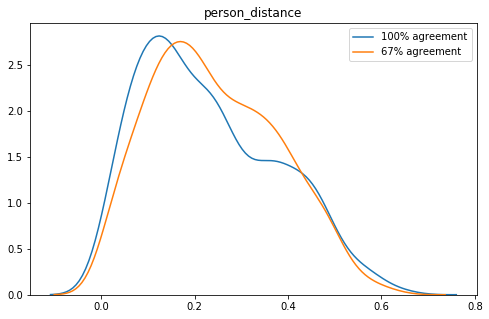

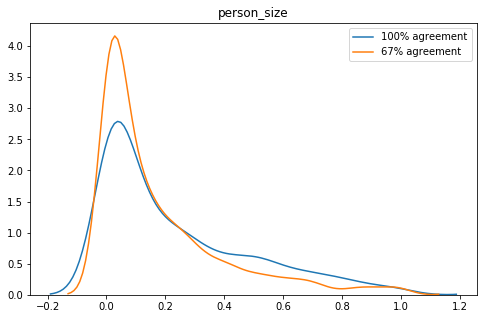

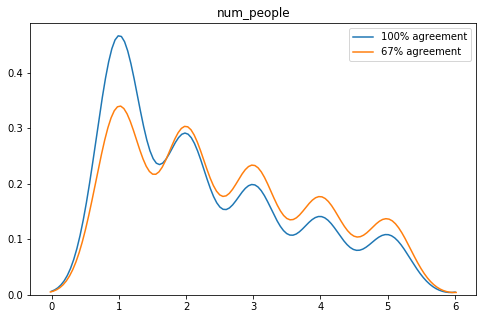

In [34]:
'''How different are the features when 67% vs 100 agreement?'''
import seaborn as sns

for f in img_level_features:
    plt.figure(figsize=(8,5))
    sns.kdeplot(feature_df.loc[agreement_100][f],  label='100% agreement')
    sns.kdeplot(feature_df.loc[agreement_23][f], label='67% agreement')
    plt.title(f)
    plt.legend()
    plt.show()


# Exploratory analysis

### Step1: predict high level features

In [29]:
'''
Model to predict 'will_num'
'''
feat = resnet_feat_avg_cols + img_level_features + link_angle_features + body_joint_prob_features + face_exp_feaures

model = linear_regression_model(input_dim=len(feat), hidden_dims=[64])

model.fit(feature_df[feat].apply(stats.zscore).values, feature_df['will_num'],
          epochs=30, batch_size=BATCH_SIZE, verbose=0)

In [30]:
feature_df['predicted_will'] =model.predict(feature_df[feat].apply(stats.zscore).values)

/nfs/nfs5-insecure/home/insecure-ro/software/rhel6_x86_64/anaconda3-4.3.0/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


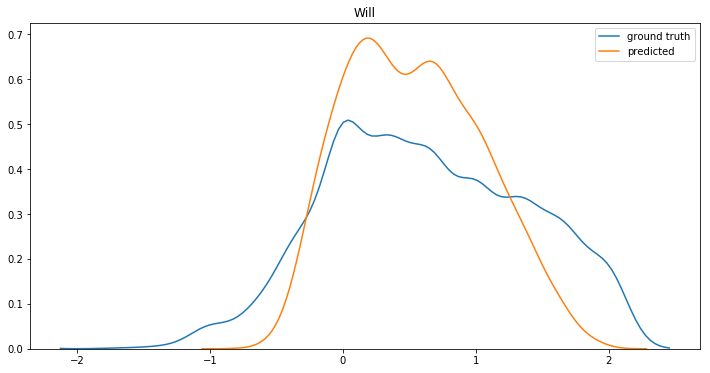

In [32]:
import seaborn as sns
plt.figure(figsize=(12,6))
sns.kdeplot(feature_df.will_num,  label='ground truth')
sns.kdeplot(feature_df.predicted_will, label='predicted')
plt.legend()
plt.title('Will')
plt.show()
#feature_df[['will_num','predicted_will']]

/nfs/nfs5-insecure/home/insecure-ro/software/rhel6_x86_64/anaconda3-4.3.0/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


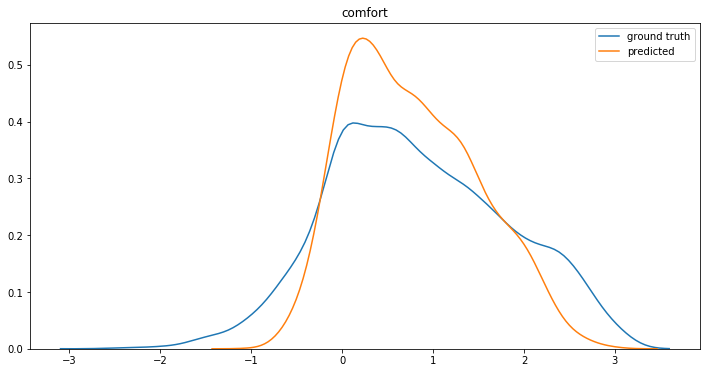

In [33]:
'''
Model to predict 'comfort'
'''
feat = resnet_feat_avg_cols + img_level_features + link_angle_features + body_joint_prob_features + face_exp_feaures

comfort_model = linear_regression_model(input_dim=len(feat), hidden_dims=[64])

comfort_model.fit(feature_df[feat].apply(stats.zscore).values, feature_df.comfort_num,
          epochs=30, batch_size=BATCH_SIZE, verbose=0)
feature_df['predicted_comfort'] =comfort_model.predict(feature_df[feat].apply(stats.zscore).values)

plt.figure(figsize=(12,6))
sns.kdeplot(feature_df.comfort_num,  label='ground truth')
sns.kdeplot(feature_df.predicted_comfort, label='predicted')
plt.title('comfort')
plt.legend()
plt.show()


/nfs/nfs5-insecure/home/insecure-ro/software/rhel6_x86_64/anaconda3-4.3.0/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


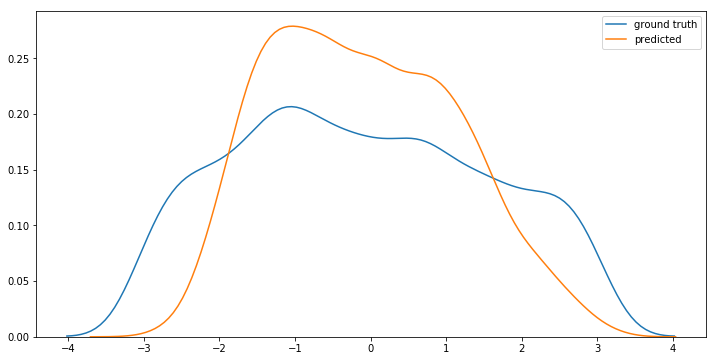

In [34]:
'''
Model to predict 'aware'
'''
feat = resnet_feat_avg_cols + img_level_features + link_angle_features + body_joint_prob_features + face_exp_feaures

model = linear_regression_model(input_dim=len(feat), hidden_dims=[64])

model.fit(feature_df[feat].apply(stats.zscore).values, feature_df.was_aware_num,
          epochs=30, batch_size=BATCH_SIZE, verbose=0)
feature_df['predicted_aware'] =model.predict(feature_df[feat].apply(stats.zscore).values)

plt.figure(figsize=(12,6))
sns.kdeplot(feature_df.was_aware_num,  label='ground truth')
sns.kdeplot(feature_df.predicted_aware, label='predicted')
plt.legend()
plt.show()


/nfs/nfs5-insecure/home/insecure-ro/software/rhel6_x86_64/anaconda3-4.3.0/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


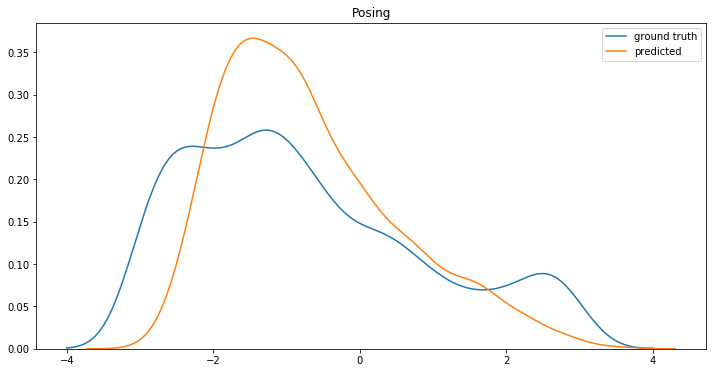

In [35]:
'''
Model to predict 'posing'
'''
feat = resnet_feat_avg_cols + img_level_features + link_angle_features + body_joint_prob_features + face_exp_feaures

model = linear_regression_model(input_dim=len(feat), hidden_dims=[64])

model.fit(feature_df[feat].apply(stats.zscore).values, feature_df.posing_num,
          epochs=30, batch_size=BATCH_SIZE, verbose=0)
feature_df['predicted_posing'] =model.predict(feature_df[feat].apply(stats.zscore).values)

plt.figure(figsize=(12,6))
sns.kdeplot(feature_df.posing_num,  label='ground truth')
sns.kdeplot(feature_df.predicted_posing, label='predicted')
plt.legend()
plt.title('Posing')
plt.show()


/nfs/nfs5-insecure/home/insecure-ro/software/rhel6_x86_64/anaconda3-4.3.0/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


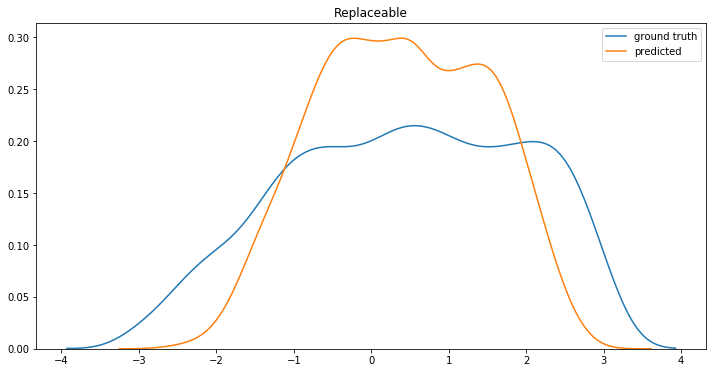

In [36]:
'''
Model to predict 'replaceable'
'''
feat = resnet_feat_avg_cols + img_level_features + link_angle_features + body_joint_prob_features + face_exp_feaures

replace_model = linear_regression_model(input_dim=len(feat), hidden_dims=[64])

replace_model.fit(feature_df[feat].apply(stats.zscore).values, feature_df.replacable_num,
          epochs=30, batch_size=BATCH_SIZE, verbose=0)
feature_df['predicted_replace'] =replace_model.predict(feature_df[feat].apply(stats.zscore).values)

plt.figure(figsize=(12,6))

sns.kdeplot(feature_df.replacable_num,  label='ground truth')
sns.kdeplot(feature_df.predicted_replace, label='predicted')
plt.legend()
plt.title('Replaceable')
plt.show()


/nfs/nfs5-insecure/home/insecure-ro/software/rhel6_x86_64/anaconda3-4.3.0/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


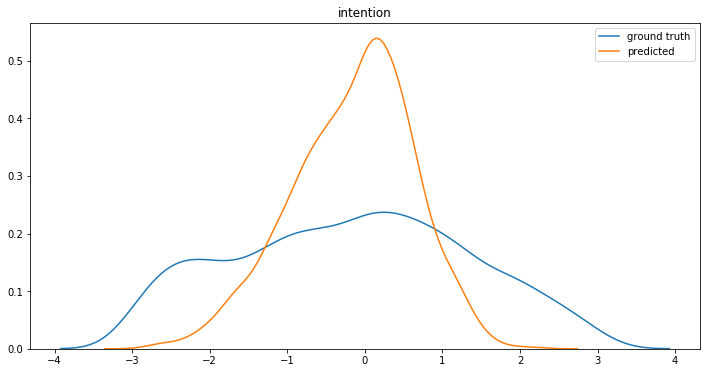

In [37]:
'''
Model to predict 'intention'
'''
feat = resnet_feat_avg_cols + img_level_features + link_angle_features + body_joint_prob_features + face_exp_feaures

intention_model = linear_regression_model(input_dim=len(feat), hidden_dims=[64])

intention_model.fit(feature_df[feat].apply(stats.zscore).values, feature_df.photographer_intention_num,
          epochs=30, batch_size=BATCH_SIZE, verbose=0)
feature_df['predicted_intention'] =intention_model.predict(feature_df[feat].apply(stats.zscore).values)

plt.figure(figsize=(12,6))

sns.kdeplot(feature_df.photographer_intention_num,  label='ground truth')
sns.kdeplot(feature_df.predicted_intention, label='predicted')
plt.legend()
plt.title('intention')
plt.show()


/nfs/nfs5-insecure/home/insecure-ro/software/rhel6_x86_64/anaconda3-4.3.0/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


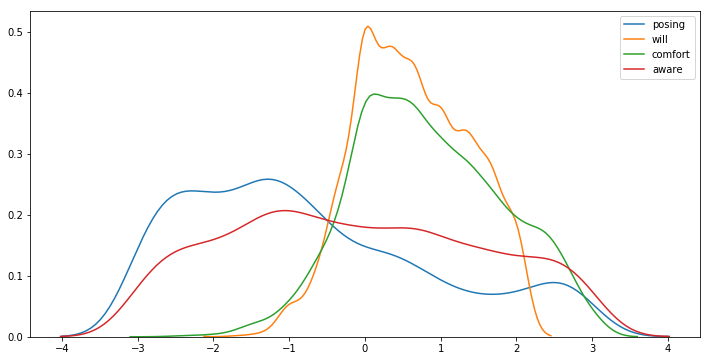

In [38]:
plt.figure(figsize=(12,6))
sns.kdeplot(feature_df.posing_num, label='posing')
sns.kdeplot(feature_df.will_num, label='will')
sns.kdeplot(feature_df.comfort_num, label='comfort')
sns.kdeplot(feature_df.was_aware_num, label='aware')
plt.legend()
plt.show()

/nfs/nfs5-insecure/home/insecure-ro/software/rhel6_x86_64/anaconda3-4.3.0/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


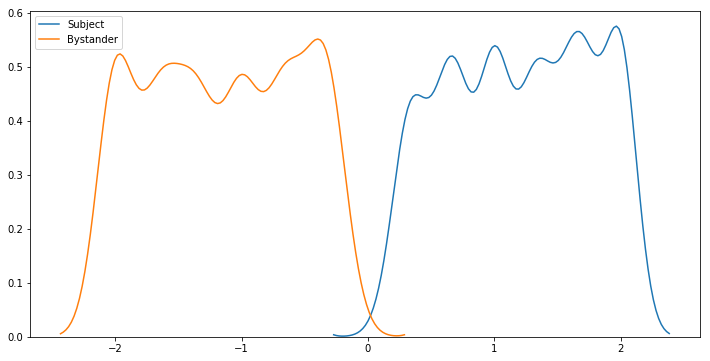

In [39]:
plt.figure(figsize=(12,6))
sns.kdeplot(feature_df[feature_df.label==1].subject_bystander_num, label='Subject')
sns.kdeplot(feature_df[feature_df.label==0].subject_bystander_num, label='Bystander')
plt.legend()
plt.show()

In [40]:
2009.19/len(feature_df.replacable_num)

0.5284560757496055

In [41]:
'''MSE'''
print('Replaceable:{:.2f}'.format(metrics.mean_squared_error(feature_df.replacable_num, feature_df.predicted_replace)))
print('Posing:{:.2f}'.format(metrics.mean_squared_error(feature_df.posing_num, feature_df.predicted_posing)))
print('Aware:{:.2f}'.format(metrics.mean_squared_error(feature_df.was_aware_num, feature_df.predicted_aware)))
print('Intention:{:.2f}'.format(metrics.mean_squared_error(feature_df.photographer_intention_num, feature_df.predicted_intention)))
print('Comfort:{:.2f}'.format(metrics.mean_squared_error(feature_df.comfort_num, feature_df.predicted_comfort)))
print('Willing:{:.2f}'.format(metrics.mean_squared_error(feature_df.will_num, feature_df.predicted_will)))


Replaceable:0.53
Posing:0.56
Aware:0.57
Intention:0.90
Comfort:0.24
Willing:0.17


## SVM with high level features

In [42]:
feat = ['will_num','replacable_num','photographer_intention_num']
print('Features:',feat)
rbf_svm = svm.SVC(kernel='rbf', C=1)
scores = cross_val_score(rbf_svm, feature_df[feat].apply(stats.zscore), feature_df.label, cv=5)
print("RBF kernel accuracy: %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))
print()

feat = ['comfort_num','replacable_num','photographer_intention_num']
print('Features:',feat)
rbf_svm = svm.SVC(kernel='rbf', C=1)
scores = cross_val_score(rbf_svm, feature_df[feat].apply(stats.zscore), feature_df.label, cv=5)
print("RBF kernel accuracy: %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))
print()


feat = features_from_study
print('Features:',feat)
rbf_svm = svm.SVC(kernel='rbf', C=1)
scores = cross_val_score(rbf_svm, feature_df[feat].apply(stats.zscore), feature_df.label, cv=5)
print("RBF kernel accuracy: %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))
print()

feat = features_from_study + img_level_features
print('Features:',feat)
rbf_svm = svm.SVC(kernel='rbf', C=1)
scores = cross_val_score(rbf_svm, feature_df[feat].apply(stats.zscore), feature_df.label, cv=5)
print("RBF kernel accuracy: %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))
print()

Features: ['will_num', 'replacable_num', 'photographer_intention_num']
RBF kernel accuracy: 85.90 (+/- 5.14)

Features: ['comfort_num', 'replacable_num', 'photographer_intention_num']
RBF kernel accuracy: 85.38 (+/- 3.97)

Features: ['was_aware_num', 'posing_num', 'comfort_num', 'will_num', 'photographer_intention_num', 'replacable_num', 'photo_place_num']
RBF kernel accuracy: 86.32 (+/- 6.02)

Features: ['was_aware_num', 'posing_num', 'comfort_num', 'will_num', 'photographer_intention_num', 'replacable_num', 'photo_place_num', 'person_distance', 'person_size', 'num_people']
RBF kernel accuracy: 88.06 (+/- 4.83)



### SVM with predicted features

In [43]:
predicted_features = ['predicted_intention', 'predicted_replace','predicted_posing',
                      'predicted_aware','predicted_comfort', 'predicted_will']

feat=['predicted_will', 'predicted_replace', 'predicted_intention']
print('Features:',feat)
rbf_svm = svm.SVC(kernel='rbf', C=1)
scores = cross_val_score(rbf_svm, feature_df[feat].apply(stats.zscore), feature_df.label, cv=5)
print("RBF kernel accuracy: %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))
print()


feat=['predicted_comfort', 'predicted_replace', 'predicted_intention']
print('Features:',feat)
rbf_svm = svm.SVC(kernel='rbf', C=1)
scores = cross_val_score(rbf_svm, feature_df[feat].apply(stats.zscore), feature_df.label, cv=5)
print("RBF kernel accuracy: %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))
print()


feat = predicted_features
print('Features:',feat)
rbf_svm = svm.SVC(kernel='rbf', C=1)
scores = cross_val_score(rbf_svm, feature_df[feat].apply(stats.zscore), feature_df.label, cv=5)
print("RBF kernel accuracy: %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))
print()

feat = predicted_features + img_level_features
print('Features:',feat)
rbf_svm = svm.SVC(kernel='rbf', C=1)
scores = cross_val_score(rbf_svm, feature_df[feat].apply(stats.zscore), feature_df.label, cv=5)
print("RBF kernel accuracy: %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))
print()

feat=['predicted_will', 'predicted_replace', 'predicted_intention']+img_level_features
print('Features:',feat)
rbf_svm = svm.SVC(kernel='rbf', C=1)
scores = cross_val_score(rbf_svm, feature_df[feat].apply(stats.zscore), feature_df.label, cv=5)
print("RBF kernel accuracy: %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))
print()


Features: ['predicted_will', 'predicted_replace', 'predicted_intention']
RBF kernel accuracy: 86.22 (+/- 4.25)

Features: ['predicted_comfort', 'predicted_replace', 'predicted_intention']
RBF kernel accuracy: 85.77 (+/- 3.40)

Features: ['predicted_intention', 'predicted_replace', 'predicted_posing', 'predicted_aware', 'predicted_comfort', 'predicted_will']
RBF kernel accuracy: 86.30 (+/- 3.11)

Features: ['predicted_intention', 'predicted_replace', 'predicted_posing', 'predicted_aware', 'predicted_comfort', 'predicted_will', 'person_distance', 'person_size', 'num_people']
RBF kernel accuracy: 87.11 (+/- 3.39)

Features: ['predicted_will', 'predicted_replace', 'predicted_intention', 'person_distance', 'person_size', 'num_people']
RBF kernel accuracy: 86.90 (+/- 3.35)



### Compare results for subsets of photos with different annotator agreement

In [44]:
agreement_23 = pickle.load(open(survey_path+'agreement23.pkl','rb'))
agreement_100 = pickle.load(open(survey_path+'agreement100.pkl','rb'))


In [53]:
def experiment(xtrain, xtest, ytrain, ytest, save_file=None):
    model = svm.SVC(kernel='rbf', C=1, probability=True)
    model = model.fit(xtrain, ytrain)
    
    probs = model.predict_proba(xtest)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(ytest, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('ROC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(fontsize=14)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.xlabel('False Positive Rate', fontsize=16)
    if save_file:
        plt.savefig(save_file, dpi=300)
    plt.show()

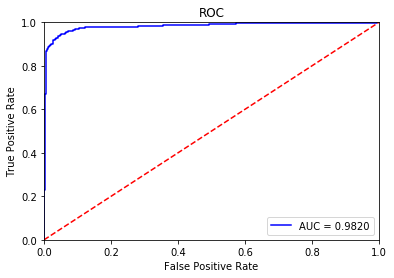

In [46]:
'''
Train will all data, test with 100% agreement
'''
feat=['predicted_will', 'predicted_replace', 'predicted_intention']
experiment(xtrain=feature_df[feat].apply(stats.zscore), 
           xtest=feature_df.loc[agreement_100][feat].apply(stats.zscore),
           ytrain = feature_df.label,
           ytest = feature_df.loc[agreement_100].label)

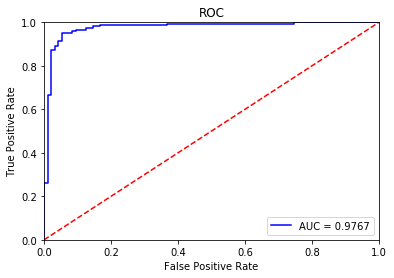

In [47]:
'''
Split 100% agreement data for training and testing
'''
df = feature_df.loc[agreement_100][feat+['label']]
train, test=train_test_split(df, test_size=0.2, random_state=1771)
experiment(xtrain=train[feat].apply(stats.zscore), 
           xtest=test[feat].apply(stats.zscore),
           ytrain = train.label,
           ytest = test.label)

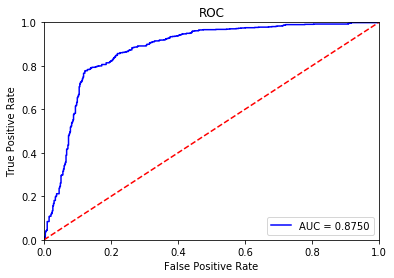

In [48]:
'''
Train with all data, test with 67% agreement
'''
experiment(xtrain=feature_df[feat].apply(stats.zscore), 
           xtest=feature_df.loc[agreement_23][feat].apply(stats.zscore),
           ytrain = feature_df.label,
           ytest = feature_df.loc[agreement_23].label)

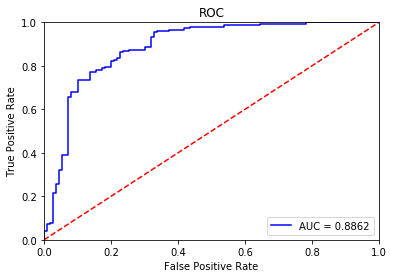

In [49]:
'''
Split 67% agreement data for training and testing
'''
df = feature_df.loc[agreement_23][feat+['label']]
train, test=train_test_split(df, test_size=0.2,random_state=1771)
experiment(xtrain=train[feat].apply(stats.zscore), 
           xtest=test[feat].apply(stats.zscore),
           ytrain = train.label,
           ytest = test.label)

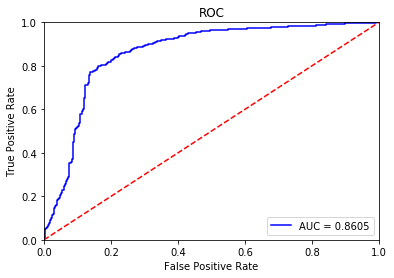

In [50]:
'''
Test with 67% agreement data, train with the remaining data
'''
train = feature_df.loc[~feature_df.index.isin(agreement_23)][feat+['label']]
test=feature_df.loc[agreement_23][feat+['label']]
experiment(xtrain=train[feat].apply(stats.zscore), 
           xtest=test[feat].apply(stats.zscore),
           ytrain = train.label,
           ytest = test.label)

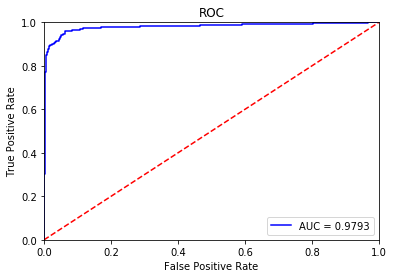

In [51]:
'''
Test with 100% agreement data, train with the remaining data
'''
train = feature_df.loc[~feature_df.index.isin(agreement_100)][feat+['label']]
test=feature_df.loc[agreement_100][feat+['label']]
experiment(xtrain=train[feat].apply(stats.zscore), 
           xtest=test[feat].apply(stats.zscore),
           ytrain = train.label,
           ytest = test.label)

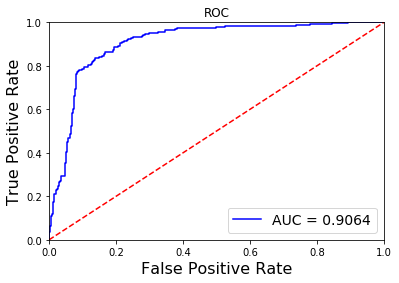

In [63]:
'''Using all data with a 80/20 split'''
feat=['person_size', 'predicted_replace', 'predicted_posing','predicted_comfort',
     'predicted_aware','person_distance','num_people']
train, test=train_test_split(feature_df, test_size=0.2, random_state=1771)
experiment(xtrain=train[feat].apply(stats.zscore), 
           xtest=test[feat].apply(stats.zscore),
           ytrain = train.label,
           ytest = test.label,
          save_file=survey_path+'predicted-high-features-roc.pdf')

In [ ]:

feat=features_from_study#['person_size', 'pose_num', 'replacable_num']
train, test=train_test_split(feature_df, test_size=0.2, random_state=1771)
experiment(xtrain=train[feat].apply(stats.zscore), 
           xtest=test[feat].apply(stats.zscore),
           ytrain = train.label,
           ytest = test.label)

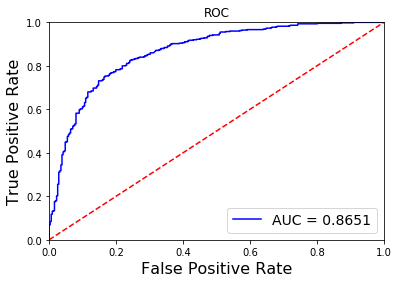

In [54]:

feat=resnet_feat_avg_cols#['person_size', 'pose_num', 'replacable_num']
train, test=train_test_split(feature_df, test_size=0.2, random_state=1771)
experiment(xtrain=train[feat].apply(stats.zscore), 
           xtest=test[feat].apply(stats.zscore),
           ytrain = train.label,
           ytest = test.label,
          save_file=survey_path+'fined-tuned-resnet-roc.pdf')

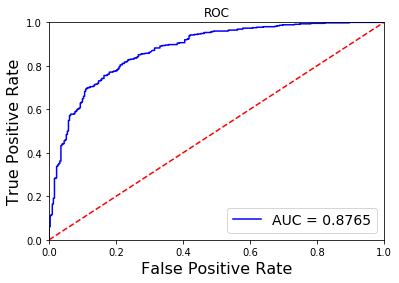

In [56]:
feat = resnet_feat_avg_cols + img_level_features + link_angle_features + body_joint_prob_features + face_exp_feaures
train, test=train_test_split(feature_df, test_size=0.2, random_state=1771)
experiment(xtrain=train[feat].apply(stats.zscore), 
           xtest=test[feat].apply(stats.zscore),
           ytrain = train.label,
           ytest = test.label,
          save_file=survey_path+'resnet-pose-angle-face-roc.pdf')